## Introduction
This notebook contains the code to reproduce the figures in the paper: "Emergent Segmentation from Participation Dynamics and Multi-Learner Retraining"

In [54]:
%load_ext autoreload
%autoreload 2

from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import ternary 
from numpy.random.mtrand import beta
from sklearn.preprocessing import normalize

from subpop import *
from learner_utils import *
from plot_utils import *

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
## Plotting settings
rc('text', usetex = False)
rc('font', family = 'serif')
context  = CONTEXT
sns.set_theme(style="whitegrid", font=FONT)

## Figure 4(a): [Synthetic] Risk dynamics over time.

Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.5, 0.5]), array([0.5, 0.5]), array([0.5, 0.5])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]


 40%|███▉      | 198/500 [00:00<00:00, 1977.64it/s]

100%|██████████| 500/500 [00:00<00:00, 2149.66it/s]


Final Conditions:
		Learners decisions: [[0.533 0.667]
 [0.533 0.667]]
		Subpopulation allocations: [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.496, 0.504]), array([0.511, 0.489]), array([0.498, 0.502])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]


100%|██████████| 500/500 [00:00<00:00, 2271.14it/s]


Final Conditions:
		Learners decisions: [[1.  1. ]
 [0.3 0.5]]
		Subpopulation allocations: [[0. 1.]
 [1. 0.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.501, 0.499]), array([0.491, 0.509]), array([0.494, 0.506])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]


100%|██████████| 500/500 [00:00<00:00, 2263.98it/s]


Final Conditions:
		Learners decisions: [[0.  1. ]
 [0.8 0.5]]
		Subpopulation allocations: [[1. 0.]
 [0. 1.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.486, 0.514]), array([0.505, 0.495]), array([0.503, 0.497])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]


100%|██████████| 500/500 [00:00<00:00, 2244.72it/s]


Final Conditions:
		Learners decisions: [[0.6 0. ]
 [0.5 1. ]]
		Subpopulation allocations: [[0. 1.]
 [0. 1.]
 [1. 0.]]


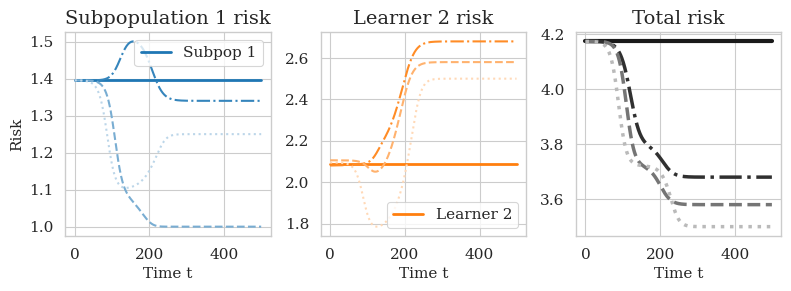

In [22]:
## -- Specify the optimal decisions for each subpopulation
phi_1 = np.array([0, 1])
phi_2 = np.array([1, 1])
phi_3 = np.array([0.6, 0])

##  -- Setup initial allocations of subpopulations to learners
allocations = [np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([[0.486, 0.505, 0.503], [0.514, 0.495, 0.497]]),
               ]  #<- select this to reproduce plots in the paper 

# allocations = [None]*4 #<- select this to run experiments  with new random initial conditions

## -- Select the type of risk minimization to be used by the learners
min_fn = quadratic_min #<- select this for noisy setting
# min_fn = quadratic_min #<- select this for noiseless updates from the learners 
# min_fn = gradient_step #<- select this for gradient descent updates from the learners

## -- Run the experiment and plot the results
T = 500 #<- number of rounds
legend_lst = [True, False, False, False] 
lw_lst = [2, 1.5, 1.5, 1.5]
ls_lst = ['-', '-.', '--', ':'] 
color_adj_lst = [1, 0.1, 0.4, 0.7,]       
with context:
    fig, axs = plt.subplots(1,3, figsize = (8,3))
    for trial in range(len(allocations)):
        alpha = allocations[trial]
        subpops = [QuadraticSubPop(phi_1, 1, alpha[:,0]), QuadraticSubPop(phi_2, 1, alpha[:,1]), QuadraticSubPop(phi_3, 1, alpha[:,2])]
        average_risks_subpop, average_risks_learner, all_risks, _, _ = run_experiment(T, subpops, min_fn=min_fn)
        ls = ls_lst[trial]
        lw = lw_lst[trial]
        color_adj = color_adj_lst[trial]
        legend = legend_lst[trial]
        plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls=ls, lw = lw, color_adj=color_adj, legend=legend, plot_learners=[1], plot_subpop = [0])
    plt.tight_layout()
    


## Figure 4(b): [Synthetic] Impact of competition on social welfare

In [23]:
##  -- Setup random seed for reproducing the results
seed = 0
rng = np.random.default_rng(0)

## -- Setup the experiment parameters
T = 1500  #<- number of rounds
n_subpops = 50 #<- number of subpopulations
n_learners_init = 2 #<- initial number of learners
n_learners_max = 20 #<- maximum number of learners
d = 8

## -- Initialize the subpopulations
phi = rng.normal(size=(n_subpops, d)) #<- optimal thetas for each subpop
alpha = np.ones(shape=(n_learners_init,n_subpops)) + rng.random(size=(n_learners_init,n_subpops))*0.0001
# alpha_ij <- fraction of subpop j going to learner i
alpha =  normalize(alpha, axis=0, norm='l1')
subpops = [QuadraticSubPop(phi[i,:], 1, alpha[:,i]) for i in range(n_subpops)]

## -- Run the experiment and plot the results
res = run_competition_experiment(T, subpops, n_learners_init=n_learners_init, n_learners_max=n_learners_max, min_fn=quadratic_min)

average_res= {k:np.mean(np.array(v), 1) for k, v in res.items()}
subpop_equilibrium_res = {k:v[-1] for k, v in res.items()}
average_equilibrium_res= {k:v[0] for k, v in average_res.items()}
break_times = {k:len(v) for k, v in average_res.items()}
break_times = np.cumsum(list(break_times.values()))

  4%|▎         | 55/1500 [00:01<00:37, 38.50it/s]


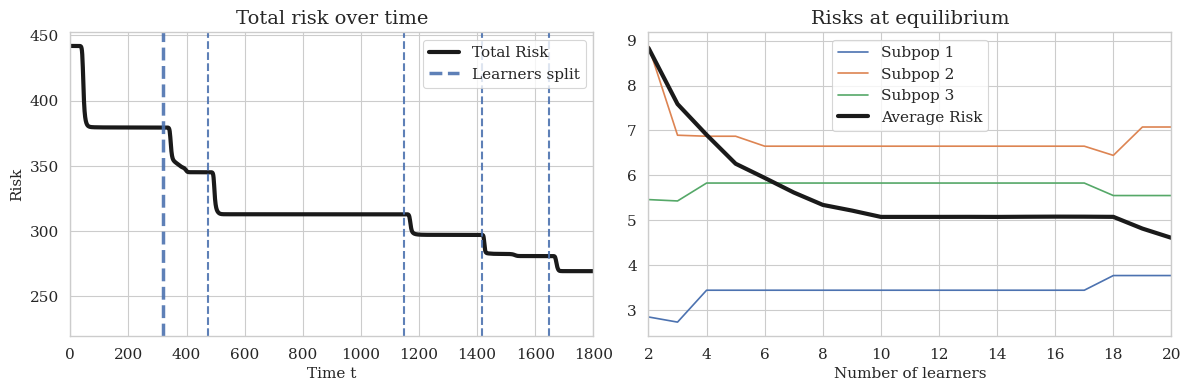

In [25]:
selected_subpops = range(3) #<- choose different subpopulations to plot the risk of alongside with total average risk.
with context:
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    axs[0].plot(n_subpops*np.concatenate((list(average_res.values()))), c='k', lw =3, label = 'Total Risk')
    for i, bt in enumerate(break_times):
        if i == 0:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 2.5, label='Learners split')
        else:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 1.5)
    axs[0].legend(loc = 1)
    axs[0].set_xlim([0, 1800])
    eq_risks = np.array(list(subpop_equilibrium_res.values()))
    axs[1].plot(range(n_learners_init, n_learners_init+len(eq_risks)), eq_risks[:,selected_subpops], label ='Subpop')
    axs[1].plot(range(n_learners_init, n_learners_init+len(eq_risks)), 
                list(average_equilibrium_res.values()), c='k', lw =3, label = 'Average Risk')
    axs[1].legend()
    axs[1].set_xlim([2, 20])
    axs[0].set_xlabel('Time t')
    axs[1].set_xlabel('Number of learners')
    axs[0].set_ylabel('Risk')
    axs[1].set_ylabel('')
    axs[0].set_title('Total risk over time')
    axs[1].set_title('Risks at equilibrium')
    h, l = axs[1].get_legend_handles_labels()
    axs[1].legend(h, ['Subpop 1', 'Subpop 2', 'Subpop 3', 'Average Risk'])
    plt.tight_layout()

## Figure 5(a): [Census] Risk dynamics over time.

In [26]:
features, label, group = generate_folktables_data()

# convert dataframes to numpy arrays
features = np.nan_to_num(np.array(features),0)
label = np.nan_to_num(np.array(label),0).flatten()
group = np.nan_to_num(np.array(group),0).flatten()

In [86]:
# -- Generate allocations
n_subpops = len(np.unique(group))
n_learners = 3
allocation = 1+0.01*np.random.randn(n_subpops, n_learners)
allocation = normalize(allocation, axis=1, norm='l1') 

# -- Instantiate the subpopulations
subpops = []
for i,g in enumerate(np.unique(group)):
    g_inds = group==g
    g_beta = np.sum(g_inds) /len(group)
    print(f'Share of subpopulation {g}: {100*g_beta:.3f}%')
    subpops.append(EmpiricalSubPop(features[g_inds], label[g_inds], g_beta, allocation[i]))
    
# --  Run the retention dynamics
T=1500
min_fn = quadratic_min
verbose = False
average_risks_subpop, average_risks_learner, all_risks, _, all_alphas = run_experiment(T, subpops, min_fn=min_fn, verbose=verbose)

Share of subpopulation 0: 61.714%
Share of subpopulation 1: 4.151%
Share of subpopulation 2: 0.637%
Share of subpopulation 3: 0.229%
Share of subpopulation 4: 17.113%
Share of subpopulation 5: 0.324%
Share of subpopulation 6: 11.769%
Share of subpopulation 7: 4.062%


  0%|          | 1/1500 [00:00<03:13,  7.73it/s]

100%|██████████| 1500/1500 [03:38<00:00,  6.87it/s]


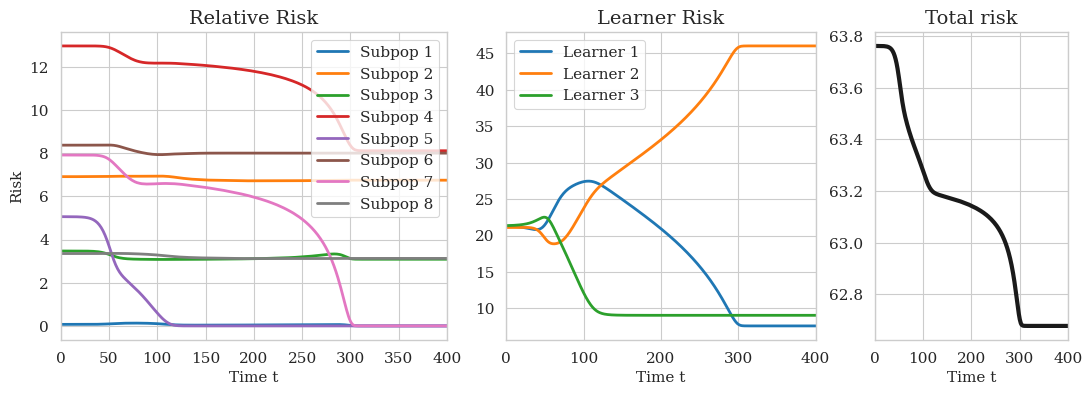

In [89]:
# -- Compute min achievable risk for each subpopulations
best_risks = []
betas = []
for i in range(len(subpops)):
    best_risks.append(subpops[i].risk(subpops[i].phi))
    betas.append(subpops[i].beta)

# -- Compute excess relative risk for each subpopulations
relative_risks_subpop = []
for i in range(len(average_risks_subpop)):
    relative_risks_subpop.append(100*((average_risks_subpop[i]/betas)/(best_risks) - 1))

with context:   
    fig, axs = plt.subplots(1,3, figsize = (13,4), gridspec_kw={'width_ratios':[1,0.8, 0.5], 'wspace': 0.2})
    plot_experiment(relative_risks_subpop, average_risks_learner, all_risks, axs,
                plot_learners=range(3), plot_subpop=range(8), legend=True)
    axs[0].set_title('Relative Risk')
    axs[1].set_title('Learner Risk')
    axs[0].set_xlim([0, 400])
    axs[1].set_xlim([0, 400])
    axs[2].set_xlim([0, 400])

## Figure 5(a): [Census] Allocation trajectories.

In [90]:
# List to hold all rows as dictionaries
rows_list = []

# Filling the list with row data
for i in range(T):
    a = all_alphas[i]
    for s in range(n_subpops):
        # Create a dictionary for each row
        row_dict = {'Step': i, 'Subpopulation': s}
        row_dict.update({f'Learner {j+1}': a[j, s] for j in range(n_learners)})
        rows_list.append(row_dict)

# Convert list of dictionaries to DataFrame
plot_df = pd.DataFrame(rows_list)

# Thin the dataframe
plot_df = plot_df[plot_df['Step'] % 5 == 0]


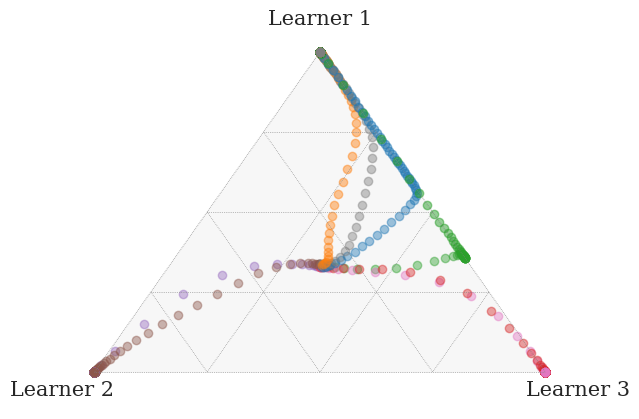

In [91]:
import warnings
warnings.filterwarnings("ignore")

# Map 'Subpopulation' values to base colors
subpopulation_colors = dict(zip(range(n_subpops), get_colors(n_subpops)))
plot_df['Color'] = plot_df['Subpopulation'].map(subpopulation_colors)
# adjust color darkness based on step 
plot_df['Alpha'] = 0.4 + 0.6 * (plot_df['Step'] / T)

# Plotting:
figure, tax = ternary.figure(scale=1.0)
tax.gridlines(color="gray", multiple=0.25)
plt.axis('off')

# Iterate over rows to plot each point with its specific color and alpha
for idx, row in plot_df.iterrows():
    color = row['Color']
    alpha = row['Alpha']    
    point = row[['Learner 1', 'Learner 2', 'Learner 3']].values
    tax.scatter([point], marker='o', c=color, alpha=alpha)

tax.clear_matplotlib_ticks()
tax.left_axis_label("")
tax.right_axis_label("")
tax.bottom_axis_label("")
# name the corners
tax.top_corner_label("Learner 1", fontsize=15)
tax.left_corner_label("Learner 2", fontsize=15)
tax.right_corner_label("Learner 3", fontsize=15)
tax.show()
